# Introduction

This project focuses on analyzing and classifying radio-loud active galactic nuclei (AGN) using a dataset derived from the Sloan Digital Sky Survey (SDSS), NRAO VLA Sky Survey (NVSS), and FIRST survey. The dataset contains 18,286 radio galaxies with various attributes, including sky coordinates, redshift, and radio flux densities. The primary goal of this project is to explore and classify these galaxies into different categories based on their radio properties and AGN characteristics.

# Imports and Configuration

In [ ]:
# Libraries Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn Modules - Preprocessing
from sklearn.preprocessing import StandardScaler  # For standardizing numerical features

# Scikit-learn Modules - Pipeline and Model Selection
from sklearn.pipeline import Pipeline  # To chain multiple estimators
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

# Scikit-learn Modules - Performance Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, roc_auc_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # Support Vector Classifier
from xgboost import XGBClassifier

# Configuration
import warnings
warnings.filterwarnings("ignore")

# Set Scikit-learn Pipeline Display to Diagram
from sklearn import set_config
set_config(display='diagram')  # Displays pipelines as diagrams


# **Dataset Structure**

---



Each row in the dataset represents a **radio galaxy** and includes the following information:

### SDSS Identifiers
- **Plate, MJD, Fiber**: Identifiers from SDSS spectroscopy.

## Sky Coordinates
- **RAhour**: Right Ascension (J2000) in hours.
- **DEdeg**: Declination (J2000) in degrees.

## Galaxy Properties
- **z**: Redshift (range 0.01 to 0.70).
- **SNVSS**: NVSS 1.4GHz integrated flux density (Jy).
- **SFIRST**: FIRST 1.4GHz integrated flux density (Jy) (missing values represented as `0`).
- **Offset**: Offset in arcseconds between the optical galaxy and the FIRST radio component.

##Classification Flags
- **RCl**: Radio classification (1 to 4, based on NVSS and FIRST matching criteria).
- **A**: Binary flag (**1** = radio-loud AGN, **0** = star-forming galaxy).
- **M**: Binary flag (**1** = part of the full statistical "main sample").
- **L**: Binary flag (**1** = low-excitation radio galaxy (LERG)).
- **H**: Binary flag (**1** = high-excitation radio galaxy (HERG)).


#Data Loading and Cleaning

In [ ]:
# Function to load the data
def load_data(file_path):
    col_names = ["Plate", "MJD", "Fiber", "RAHour", "DDecl", "z", "SNVSS", "SFIRST",
                 "Offset", "Radio_Class", "A", "M", "L", "H"]
    data = pd.read_csv(file_path, delim_whitespace=True, names=col_names, comment='#')
    data = data.drop(columns=["M", "L", "H"], axis=1)
    return data


file_path = "/content/table1.dat"
data = load_data(file_path)



In [ ]:
data.head()


,Plate,MJD,Fiber,RAHour,DDecl,z,SNVSS,SFIRST,Offset,Radio_Class,A
0,266,51602,5,9.784227,-0.81043,0.44864,0.0069,1,0.0042,1.76,1
1,266,51602,26,9.797071,-0.34230,0.13483,0.0963,1,0.1010,1.26,1
2,266,51602,100,9.742906,-0.74164,0.20389,0.0068,1,0.0025,0.46,1
3,266,51602,109,9.782475,-0.25218,0.13048,0.0075,1,0.0043,0.51,1
4,266,51602,134,9.720425,-0.54706,0.36795,0.0091,2,0.0000,-1.00,1


# Exploratory Data Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18286 entries, 0 to 18285
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Plate        18286 non-null  int64  
 1   MJD          18286 non-null  int64  
 2   Fiber        18286 non-null  int64  
 3   RAHour       18286 non-null  float64
 4   DDecl        18286 non-null  float64
 5   z            18286 non-null  float64
 6   SNVSS        18286 non-null  float64
 7   SFIRST       18286 non-null  int64  
 8   Offset       18286 non-null  float64
 9   Radio_Class  18286 non-null  float64
 10  A            18286 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 1.5 MB


In [ ]:
data.describe()

,Plate,MJD,Fiber,RAHour,DDecl,z,SNVSS,SFIRST,Offset,Radio_Class,A
count,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000
mean,1495.570600,53100.310401,321.158154,12.153572,24.814904,0.228318,0.034084,1.371486,0.014173,0.561715,0.836706
std,733.636979,806.110899,184.045787,3.812329,18.546869,0.138812,0.219618,0.781642,0.175637,1.119436,0.369644
min,266.000000,51602.000000,1.000000,0.000437,-11.198980,0.010070,0.005000,1.000000,0.000000,-1.000000,0.000000
25%,860.000000,52379.000000,162.000000,9.877838,9.449515,0.114515,0.006900,1.000000,0.002600,0.150000,1.000000
50%,1455.000000,53083.000000,321.000000,12.189186,23.955245,0.212575,0.011200,1.000000,0.005400,0.400000,1.000000
75%,2109.000000,53786.000000,481.000000,14.605974,39.026850,0.339990,0.023500,1.000000,0.010500,0.900000,1.000000
max,2974.000000,54623.000000,640.000000,23.999668,64.434970,0.695050,22.720300,4.000000,22.171100,10.000000,1.000000


In [ ]:
sns.set()

<Axes: xlabel='A', ylabel='count'>

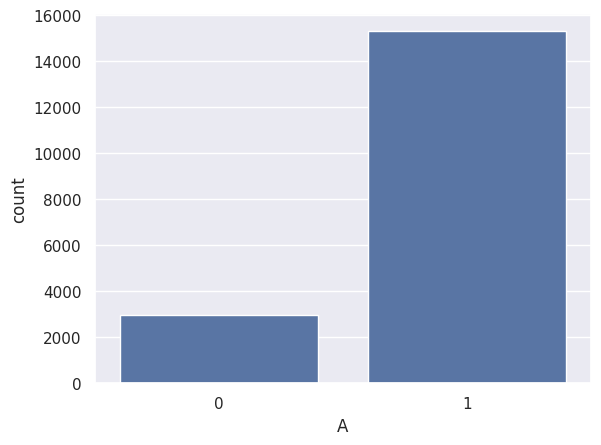

In [ ]:
sns.countplot(data= data, x='A')

<Axes: xlabel='Plate', ylabel='Density'>

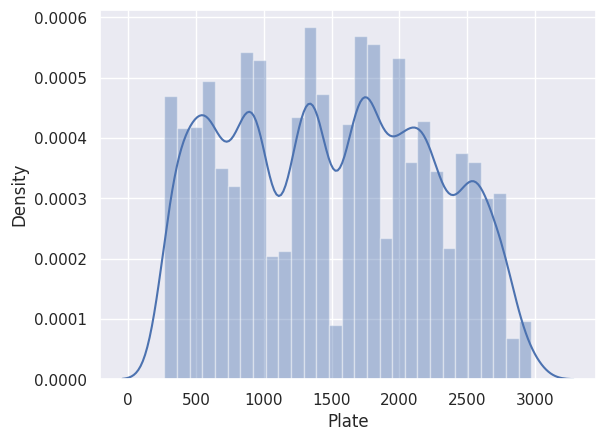

In [ ]:
sns.distplot(data['Plate'])

<Axes: xlabel='MJD', ylabel='Density'>

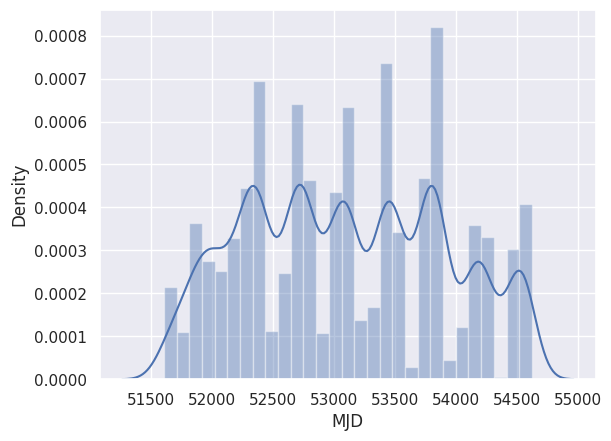

In [ ]:
sns.distplot(data['MJD'])

<Axes: xlabel='Fiber', ylabel='Density'>

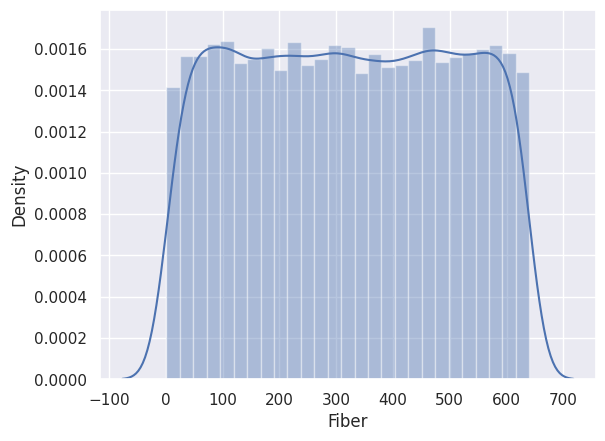

In [ ]:
sns.distplot(data['Fiber'])

<Axes: xlabel='RAHour', ylabel='Density'>

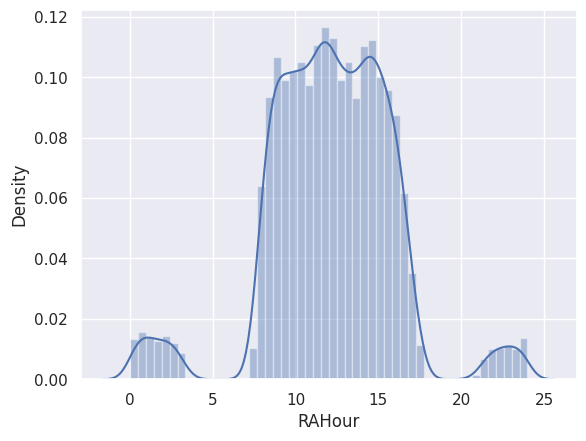

In [ ]:
sns.distplot(data['RAHour'])

<Axes: xlabel='DDecl', ylabel='Density'>

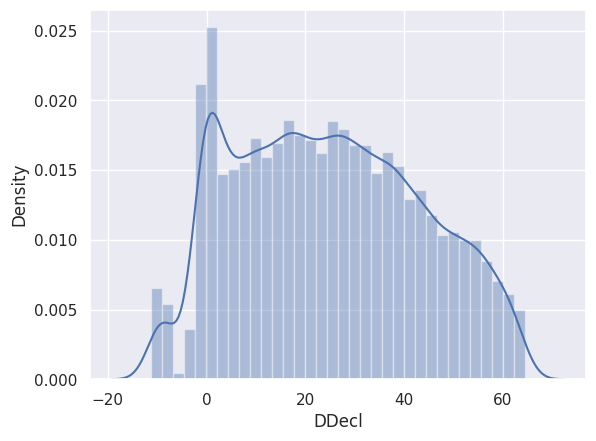

In [ ]:
sns.distplot(data['DDecl'])

<Axes: xlabel='z', ylabel='Density'>

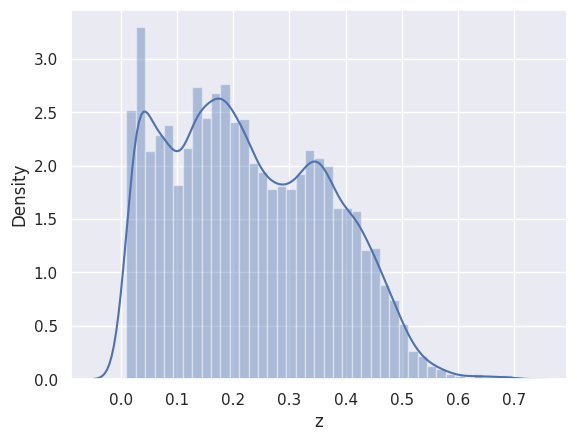

In [ ]:
sns.distplot(data['z'])

<Axes: xlabel='SNVSS', ylabel='Density'>

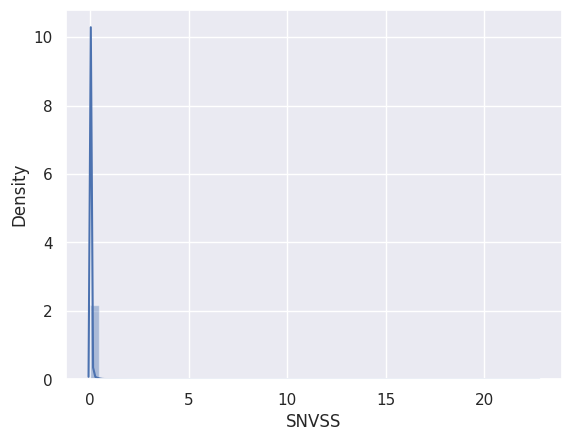

In [ ]:
sns.distplot(data['SNVSS'])

<Axes: xlabel='SFIRST', ylabel='Density'>

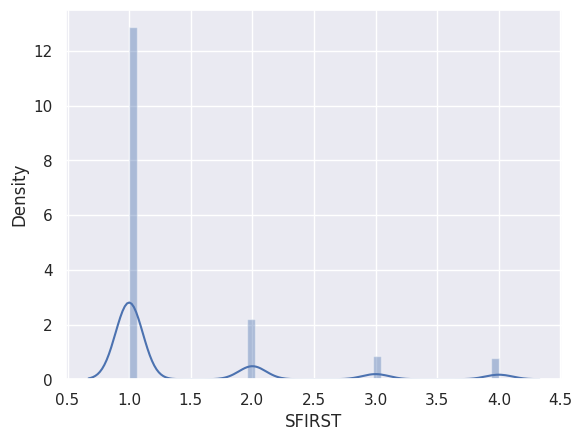

In [ ]:
sns.distplot(data['SFIRST'])

<Axes: xlabel='Offset', ylabel='Density'>

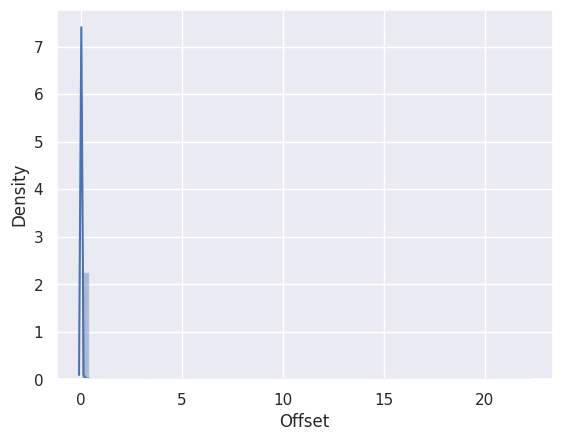

In [ ]:
sns.distplot(data['Offset'])

<Axes: xlabel='Radio_Class', ylabel='Density'>

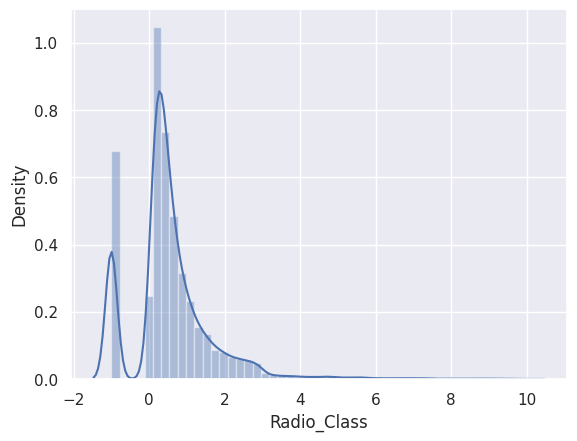

In [ ]:
sns.distplot(data['Radio_Class'])

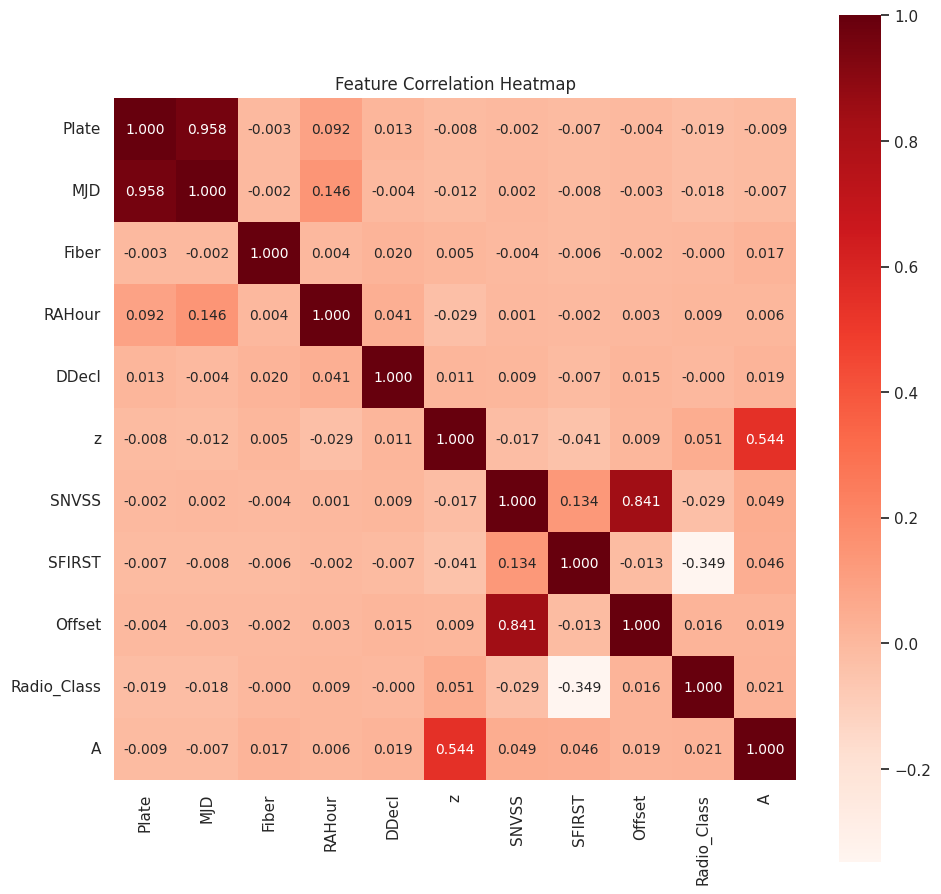

In [ ]:
plt.figure(figsize=(11, 11))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, cbar=True, square=True, fmt='.3f', annot=True, annot_kws={'size':10}, cmap='Reds')
plt.title('Feature Correlation Heatmap')
plt.show()

# **Feature Importance Analysis**  

Understanding which features contribute the most to classifying **radio-loud AGN** is crucial for improving model performance and gaining astrophysical insights. Feature importance analysis helps identify the most influential variables in distinguishing between **radio-loud AGN** and **star-forming galaxies**.  

In this section, we use the **XGBoost classifier** to compute feature importance scores. By analyzing these scores, we can determine which attributes—such as redshift, radio flux densities, and spatial offsets—play the most significant roles in classification.  

  


In [ ]:
# Plot feature importance
def plot_feature_importance(model, feature_names):
    # Get feature importance
    importance = model.feature_importances_

    # DataFrame for visualization
    feature_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()


In [ ]:
features = ["Plate", "MJD", "Fiber", "RAHour", "DDecl", "z", "SNVSS", "SFIRST","Offset", "Radio_Class"]
target = "A"

data2 = data[features + [target]]
data2 = data2.apply(pd.to_numeric)
Z = data2[features]
y = data2[target]

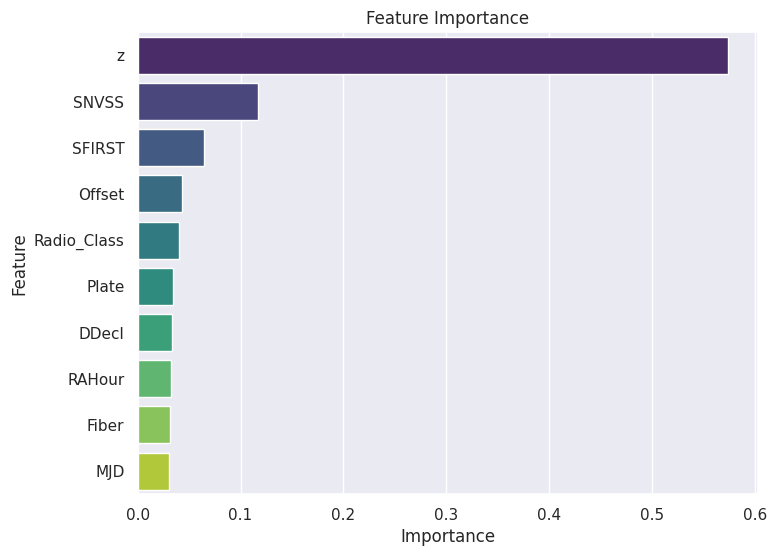

In [ ]:
# Split the data
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
Z_train_scaled = scaler.fit_transform(Z_train)
Z_test_scaled = scaler.transform(Z_test)

# Train the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(Z_train_scaled, y_train)

# Plot feature importance
plot_feature_importance(model, Z.columns)



# **Comparing Full Models vs. Restricted Models**  

To assess the impact of feature selection on model performance, we compare two different approaches:  
1. **Full Model** – Utilizes all available features.  
2. **Restricted Model** – Uses a subset of the most important features.  

### **Objective of the Comparison:**  
- Evaluate whether using fewer, more relevant features improves model efficiency without sacrificing accuracy.  
- Reduce computational complexity while maintaining predictive power.  
- Understand how different features contribute to AGN classification.  

By comparing these models, we determine whether reducing the number of features leads to a **simpler, faster, and equally effective classification model**.  


In [ ]:
full_features = ["Plate", "MJD", "Fiber", "RAHour", "DDecl", "z",
                 "SNVSS", "SFIRST", "Offset", "Radio_Class"]
restricted_features = ["z", "SNVSS", "SFIRST", "Offset", "Radio_Class"]

In [ ]:
# For full model
data_full = data[full_features + [target]]
data_full = data_full.apply(pd.to_numeric)
X_full = data_full[full_features]
y_full = data_full[target]

In [ ]:
# For restricted model
data_restricted = data[restricted_features + [target]]
data_restricted = data_restricted.apply(pd.to_numeric)
X_restricted = data_restricted[restricted_features]
y_restricted = data_restricted[target]

In [ ]:
# Train/Test Split (Same proportions and random state)
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

X_restricted_train, X_restricted_test, y_restricted_train, y_restricted_test = train_test_split(
    X_restricted, y_restricted, test_size=0.2, random_state=42, stratify=y_restricted
)


In [ ]:
# Full Model Pipeline
pipeline_full = Pipeline([
    ("scaler", StandardScaler()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])
pipeline_full

Pipeline(steps=[('scaler', StandardScaler()),
                ('XGBoost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Restricted Model Pipeline
pipeline_restricted = Pipeline([
    ("scaler", StandardScaler()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
pipeline_restricted

Pipeline(steps=[('scaler', StandardScaler()),
                ('XGBoost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Fit the Models
pipeline_full.fit(X_full_train, y_full_train)
pipeline_restricted.fit(X_restricted_train, y_restricted_train)

# Make Predictions on Test Sets
y_full_pred = pipeline_full.predict(X_full_test)
y_restricted_pred = pipeline_restricted.predict(X_restricted_test)

In [ ]:
# For the full model, get the probability for the positive class (assumed to be class "1")
y_full_pred_proba = pipeline_full.predict_proba(X_full_test)[:, 1]
y_restricted_pred_proba = pipeline_restricted.predict_proba(X_restricted_test)[:, 1]

# Log Loss
log_loss_full = log_loss(y_full_test, y_full_pred_proba)
log_loss_restricted = log_loss(y_restricted_test, y_restricted_pred_proba)

# ROC-AUC Score
roc_auc_full = roc_auc_score(y_full_test, y_full_pred_proba)
roc_auc_restricted = roc_auc_score(y_restricted_test, y_restricted_pred_proba)

In [ ]:
# Evaluate and Compare the Models

print("----- Full Model Performance -----")
print("Accuracy:", accuracy_score(y_full_test, y_full_pred))
print("Classification Report:\n", classification_report(y_full_test, y_full_pred))
print("Confusion Matrix:\n", confusion_matrix(y_full_test, y_full_pred))
print("Log Loss: {:.4f}".format(log_loss_full))
print("ROC-AUC: {:.4f}".format(roc_auc_full))

print("\n----- Restricted Model Performance -----")
print("Accuracy:", accuracy_score(y_restricted_test, y_restricted_pred))
print("Classification Report:\n", classification_report(y_restricted_test, y_restricted_pred))
print("Confusion Matrix:\n", confusion_matrix(y_restricted_test, y_restricted_pred))
print("Log Loss: {:.4f}".format(log_loss_restricted))
print("ROC-AUC: {:.4f}".format(roc_auc_restricted))

----- Full Model Performance -----
Accuracy: 0.937944231820667
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80       597
           1       0.96      0.97      0.96      3061

    accuracy                           0.94      3658
   macro avg       0.90      0.87      0.88      3658
weighted avg       0.94      0.94      0.94      3658

Confusion Matrix:
 [[ 462  135]
 [  92 2969]]
Log Loss: 0.1694
ROC-AUC: 0.9676

----- Restricted Model Performance -----
Accuracy: 0.934117003827228
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79       597
           1       0.95      0.97      0.96      3061

    accuracy                           0.93      3658
   macro avg       0.89      0.86      0.88      3658
weighted avg       0.93      0.93      0.93      3658

Confusion Matrix:
 [[ 455  142]
 [  99 2962]]
Log Loss: 0.1733
ROC-AUC: 0.9653


# **Comparing Different Classification Models on Restricted Data**  

After selecting the most relevant features, it is important to evaluate how different machine learning classifiers perform in classifying **radio-loud AGN** versus **star-forming galaxies**. This section compares multiple classification models using the **restricted feature set** to determine which algorithm provides the best predictive accuracy.   
By comparing these classifiers, we can determine which model offers the best balance between **accuracy, computational efficiency, and robustness** for classifying radio-loud AGN.


In [ ]:
# Define classifiers to evaluate
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42)  # probability=True for predict_proba
}


In [ ]:
# Function to evaluate a classifier and return evaluation metrics in a dictionary
def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", clf)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # probability of the positive class

    acc = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    lloss = log_loss(y_test, y_pred_proba)
    roc = roc_auc_score(y_test, y_pred_proba)

    return {
        "accuracy": acc,
        "classification_report": class_report,
        "confusion_matrix": conf_matrix,
        "log_loss": lloss,
        "roc_auc": roc
    }



In [ ]:
# Loop over each classifier and print its performance
for name, clf in classifiers.items():
    print(f"----- {name} -----")
    metrics = evaluate_classifier(clf, X_restricted_train, y_restricted_train, X_restricted_test, y_restricted_test)
    print("Accuracy: {:.4f}".format(metrics["accuracy"]))
    print("Classification Report:\n", metrics["classification_report"])
    print("Confusion Matrix:\n", metrics["confusion_matrix"])
    print("Log Loss: {:.4f}".format(metrics["log_loss"]))
    print("ROC-AUC: {:.4f}".format(metrics["roc_auc"]))
    print("\n")

----- Logistic Regression -----
Accuracy: 0.9308
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79       597
           1       0.96      0.96      0.96      3061

    accuracy                           0.93      3658
   macro avg       0.87      0.88      0.87      3658
weighted avg       0.93      0.93      0.93      3658

Confusion Matrix:
 [[ 480  117]
 [ 136 2925]]
Log Loss: 0.1756
ROC-AUC: 0.9641


----- K-Nearest Neighbors -----
Accuracy: 0.9297
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78       597
           1       0.95      0.96      0.96      3061

    accuracy                           0.93      3658
   macro avg       0.88      0.86      0.87      3658
weighted avg       0.93      0.93      0.93      3658

Confusion Matrix:
 [[ 456  141]
 [ 116 2945]]
Log Loss: 0.8500
ROC-AUC: 0.9293


----- Decision Tree -----
Accuracy: 0.